# 3D U-Net Model for Predicting Nodules from Lung CT

In [1]:
import numpy as np
import keras
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

/Users/sumangunnala/anaconda2/envs/tensorflow_keras/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [42]:
import pandas as pd
import numpy as np
import h5py
import pandas as pd
import argparse
import SimpleITK as sitk
from PIL import Image
import os, glob 
import os, os.path
import tensorflow as tf
import keras

from ipywidgets import interact
import json
import pickle
from datetime import datetime
from tqdm import tqdm, trange

%matplotlib inline

## Load the trained Keras model.

In [2]:
filename = "final_unet3d_model.hdf5"
model = keras.models.load_model(filename)

/Users/sumangunnala/anaconda2/envs/tensorflow_keras/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Load the CT Scans
This is from the hdf5 file of extracted patches. The scan is 256 mm x 256 mm x 128 mm. It takes roughly 35 GB of RAM in order to make a prediction on the entire volume at once.

In [3]:
ct_scan = h5py.File("/Users/sumangunnala/Documents/DSE/sgunnala/Capstone/dataset/luna16_DATA/hdf5files/256x256x128-patch-withdiam.hdf5", "r")

In [4]:
list(ct_scan.keys())

['centroid', 'diameter_label', 'input', 'notrain', 'output', 'subsets', 'uuid']

In [5]:
class1idx = []
class0idx = []
for idx in range(390):
    if ct_scan["output"][idx] == [1]:
        class1idx.append(idx)
    else:
        class0idx.append(idx)

In [6]:
class1idx

[115, 130]

In [7]:
def save_imgs(img, prediction_mask, classidx, classtype):
    
    origin = "lower"
    
    for sliceNo in range(max(img.shape)):


        plt.figure(figsize=(15,15))


        plt.subplot(2,3,1)
        plt.imshow(img[sliceNo,:,:,0], cmap="bone", origin=origin)
        plt.title("Original Image", fontsize=18)
        plt.text(-40,32,"Transverse\n    plane", fontsize=32, color="blue", fontname="FreeSans")

        plt.subplot(2,3,2)
        plt.imshow(prediction_mask[0,sliceNo,:,:,0], cmap="bone", origin=origin)
        plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")

        plt.subplot(2,3,3)
        plt.imshow(img[sliceNo,:,:,0], cmap="bone", origin=origin)
        plt.imshow(prediction_mask[0,sliceNo,:,:,0], alpha=0.5, cmap="Reds", origin=origin)
        #plt.colorbar()
        plt.title("Overlay", fontsize=18, fontname="FreeSans")

        plt.subplot(2,3,4)
        plt.imshow(img[:,sliceNo,:,0], cmap="bone", origin=origin)
        plt.title("Original Image", fontsize=18)
        plt.text(-37,32,"Sagittal\n  plane", fontsize=32, color="blue", fontname="FreeSans")
        plt.xlabel("mm", fontsize=18, fontname="FreeSans")

        plt.subplot(2,3,5)
        plt.imshow(prediction_mask[0,:,sliceNo,:,0], cmap="bone", origin=origin)
        plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")
        plt.xlabel("mm", fontsize=18, fontname="FreeSans")

        plt.subplot(2,3,6)
        plt.imshow(img[:,sliceNo,:,0], cmap="bone", interpolation="none", origin=origin)
        plt.xlabel("mm", fontsize=18, fontname="FreeSans")

        plt.imshow(prediction_mask[0,:,sliceNo,:,0], alpha=0.5, cmap="Reds", origin=origin)
        #plt.colorbar()
        plt.title("Overlay", fontsize=18, fontname="FreeSans")

        plt.tight_layout()

        import os
        directory = "saved_imgs/class{}/candidate{}/".format(classtype,classidx)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig("{}slice{}".format(directory, sliceNo), dpi=600, bbox_inches="tight")

        plt.close()


## It takes roughly 35 GB and 20 seconds to make a prediction on this volume.

The predictions have been saved to the file fullscan_prediction.npz. If you don't have enough memory to make the prediction then skip the next cell and do the np.load instead.

In [14]:
# %%time

# img = ct_scan["input"][130,:].reshape(128,256,256,1)  

# # centerX = 64
# # centerY = 64
# # centerZ = 64
# # extentX = 96//2
# # extentY = 96//2
# # extentZ = 96//2
# centerX = 64
# centerY = 128
# centerZ = 128
# extentX = 128//2
# extentY = 256//2
# extentZ = 256//2
# img = img[(centerX-extentX):(centerX+extentX),(centerY-extentY):(centerY+extentY),(centerZ-extentZ):(centerZ+extentZ)]

# predict_array = model.predict(np.expand_dims(img,0), verbose=2)

# prediction_mask = np.round(predict_array[0])
# feature_maps = np.round(predict_array[1])

In [33]:
#feature_maps, prediction_mask, imgs = np.load("fullscan_predict.npz") #does not unpack for you....
fullscan_predict_objs = np.load("./fullscan_predict.npz") #correct way to call returning a dict obj
#np.savez("fullscan_predict.npz", img=img, prediction_mask=prediction_mask, feature_maps=feature_maps) #not necessarilly needed...

In [36]:
print(fullscan_predict_objs.keys())
print(type(fullscan_predict_objs['feature_maps']))
print(type(fullscan_predict_objs['prediction_mask']))
print(type(fullscan_predict_objs['img']))

['feature_maps', 'prediction_mask', 'img']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [37]:
feature_maps = fullscan_predict_objs['feature_maps']
prediction_mask = fullscan_predict_objs['prediction_mask']
img = fullscan_predict_objs['img']

In [38]:
def plotpatch(sliceNo):
    
    m=4 #3,4
    origin = "bottom"

    plt.figure(figsize=(15,15))

    plt.subplot(3,3,1)
    plt.imshow(img[sliceNo,:,:,0], cmap="bone", origin=origin)
    plt.title("Original Image", fontsize=18)
    
    plt.subplot(3,3,2)
    plt.imshow(prediction_mask[0,sliceNo,:,:,0], cmap="bone", origin=origin)
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")

    plt.subplot(3,3,3)
    plt.imshow(img[sliceNo,:,:,0], cmap="bone", origin=origin)
    plt.imshow(feature_maps[0,sliceNo,:,:,m], alpha=0.5, cmap="Reds", origin=origin)
    plt.title("Feature Map #{}".format(m), fontsize=18, fontname="FreeSans")

    plt.subplot(3,3,4)
    plt.imshow(img[:,sliceNo,:,0], cmap="bone", origin=origin)
    plt.title("Original Image", fontsize=18)
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.subplot(3,3,5)
    plt.imshow(prediction_mask[0,:,sliceNo,:,0], cmap="bone", origin=origin)
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.subplot(3,3,6)
    plt.imshow(img[:,sliceNo,:,0], cmap="bone", interpolation="none", origin=origin)
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.imshow(feature_maps[0,:,sliceNo,:,m], alpha=0.5, cmap="Reds", origin=origin)
    plt.title("Feature map #{}".format(m), fontsize=18, fontname="FreeSans")
    
    plt.subplot(3,3,7)
    plt.imshow(img[:,:,sliceNo,0], cmap="bone", origin=origin)
    plt.title("Original Image", fontsize=18)
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.subplot(3,3,8)
    plt.imshow(prediction_mask[0,:,:,sliceNo,0], cmap="bone", origin=origin)
    plt.title("Tumor Prediction", fontsize=18, fontname="FreeSans")
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.subplot(3,3,9)
    plt.imshow(img[:,:,sliceNo,0], cmap="bone", interpolation="none", origin=origin)
    plt.xlabel("mm", fontsize=18, fontname="FreeSans")

    plt.imshow(feature_maps[0,:,:,sliceNo,m], alpha=0.5, cmap="Reds", origin=origin)
    plt.title("Feature map #{}".format(m), fontsize=18, fontname="FreeSans")

    plt.tight_layout()
  

/Users/sumangunnala/anaconda2/envs/tensorflow_keras/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


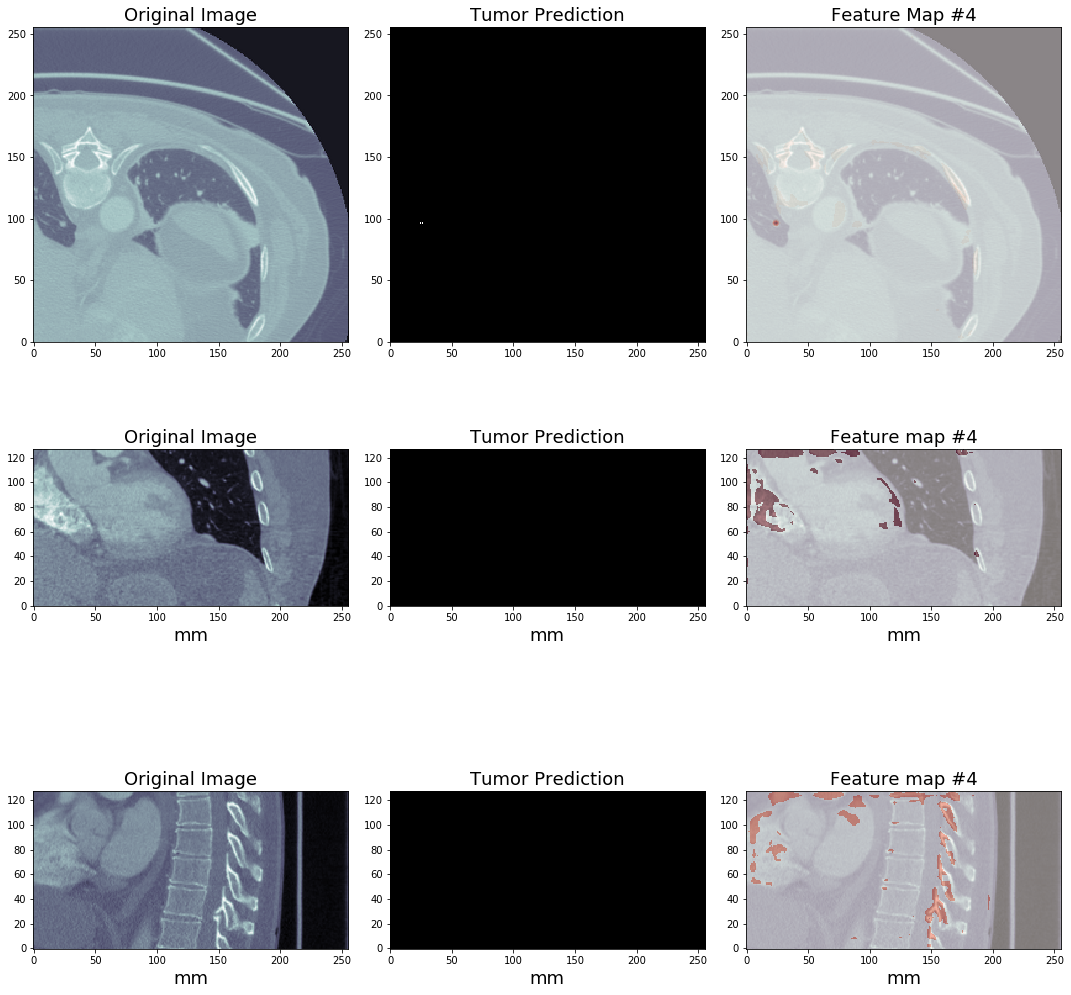

In [52]:
plotpatch(48)        # 48, 64, 73

#73 is missing nodule
#48,64 is the nodule that is captured

A Jupyter Widget

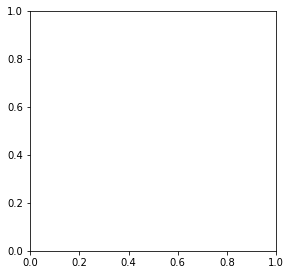

In [49]:
interact(plotpatch, sliceNo=(1,img.shape[2],1)); #172

In [44]:
img.shape

(128, 256, 256, 1)